


# Imbalanced Data Lecture

Author: Ethan Robert A. Casin

---

For our lesson today, we re going throughout the ML Development. We are specifically focusing on preprocessing. In the lab, we will also deal with post-processing. In a nutshell, ML development is:
* Preprocessing
* Model
* Postprocessing
* Explainable AI

## Overview

This notebook would be the main reference material in understanding class imbalance and the methods on how to handle them. Although this lecture doesn't provide an exhaustive list of methods and current state-of-the-art (SOTA) techniques, understanding the algorithm here would provide the learners a good foundation should they choose and need to learn more advanced techniques. 

The goals for this session are:
1. To equip students with fundamental sampling techniques, namely, random under-/over- sampling, SMOTE, SMOTE-NC, SMOTE-N, and ADASYN
2. To enable students to be comfortable in math notations and understand ML pipeline code in `scikit-learn` and `imblearn`
3. To show students the value of preprocessing methods and how it can affect downstream ML performance

---

# Introduction

In many real-world data science projects hadnling imbalanced data sets are common. Weirdly, balanced datasets are actually rarer than imbalanced ones because real-world behavior don't always have equal likelihoods. 

With all this talk about imbalanced datasets, what are they in the first place? 

We call a dataset **imbalanced** if the number of positive and negative labels are not equal. In contrast, a **balanced** dataset occurs when we have the same number of positive and negative labels. To make it more general, there could be any number of classes in our dataset. Typically, $n_{\text{classes}} \geq 2$. In many of the methods we'll learn here the implementations often just distinguish between *minority* and *majority* classes. 

A typical example of a real-world imbalanced data set would be cancer detection, where people who have cancer are often the "minority" class. The simple reason: cancer is rare if we compare it to the rest of the population. Another example would be credit card fraud, where fraud detection cases often deal with severly imbalanced data. 

Those who are caught for credit card fraud is that those who are caught are just terrible. It's only illegal if you only get caught mwhehehehhe. The experts would be the one that should not even get caught.

We need to properly treat class imbalance to be able to learn the patterns of the minority class.


In this lecture, we'll learn how to handle imbalanced data. From more basic methods to more advanced oversampling strategies, we'll learn what are the fundamental and modern methods to treat imbalanced data. 


In [61]:
import warnings

from typing import List, Optional, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score, confusion_matrix

warnings.filterwarnings("ignore")
%matplotlib inline

### Load Data

Before we begin, we must understand what our dataset is. For this lecture we'll be using the [Prima Indians Diabetes Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download) curated by UCI Machine Learning. 

You can read more about the context of the dataset from the link provided. Should you need more information, you can refer to this documentation from [OpenML](https://www.openml.org/search?type=data&id=43483&sort=runs&status=active). Overall this is a classic example of an imbalanced dataset and we might see this dataset again in the future.

In [62]:
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


To understand what we're dealing with, let's plot out the classes and their counts.

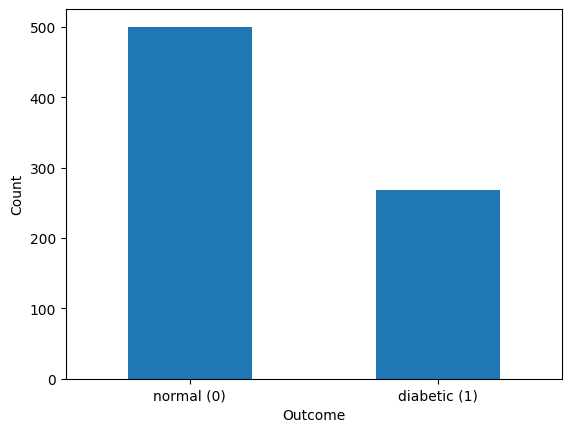

In [63]:
plt.figure()

target = data["Outcome"]
class_mapping = {0: "normal (0)", 1: "diabetic (1)"}
target.map(class_mapping).value_counts().plot.bar(rot=0)

plt.ylabel("Count")
plt.show()

## Baseline

Before we move to our discussion, we first need to establish a baseline. The entirety of the steps we'll do can be seen here.

### Creation of our train-val-test splits

We do this to simulate the actual production settings. The test split is called the hold-out. The validation set is just to see how it holds up in unseen data. 

You stratify to make sure that everything in out split is to be constant. It preserves the proportion of the classes. 

With any modeling effort, we need to separate our holdout set. The holdout set is used as the final assessment for our modeling. In practice, the hold out set happens on actual data after all of the model training and pipelines have been finalized. Commonly, unseen production data. 

In our discussion, we will use the holdout set to get our final assessment on each of the methods we'll discuss here. We'll get a standard 20% of the whole dataset as our holdout. Because we have an imbalanced dataset, we need to **preserve the actual distribution of our labels during training and testing**. We do that by setting the `stratify` parameter in the `train_test_split` function of `sklearn`.

In [64]:
# Creation of our hold-out set

X, y = data.iloc[:, :-1], data.iloc[:, -1]

X_Train, X_test, y_Train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=target
)

# Creation of a train-validation set
# We'll be adjusting this repeatedly in the notebook
# take note of the capitalized 'Train'.
# The dataframes we'll be primarily using is X_Train and y_Train.
X_train, X_val, y_train, y_val = train_test_split(
    X_Train, y_Train, test_size=0.2, random_state=0, stratify=y_Train
)

# print out the training and validation set sizes
print(f"X shape: {X.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_val shape: {X_val.shape}")

X shape: (768, 8)
X_train shape: (491, 8)
X_test shape: (154, 8)
X_val shape: (123, 8)


Now that we have our holdout set, we can further divide our `X_Train` and `y_Train` into training and validation samples. The validation set would help us assess the models' performance on unseen data **before** the final assessment: the holdout set.

### Baseline Modeling

For grid search, we have a list of hyperparameters that we have with the specific variables. For examples, the parameters just for C can be 1, 0.1, 0.001 and then the penalty is l1, l2, none. Then, we grid search. For the randomized, random the parameters and when it is no longer impproving, stop. When you have a small model, just do gridsearch. If we are lacking on time, we just do randomized search CV.

For the purposes of the lecture, let's not overcomplicate our lives by choosing which model fits best. Our baseline, and our main model, would be the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

Let's do it some justice, we can do a comparison of an untuned model and a somewhat tuned version using `RandomizedSearchCV`. To streamline repeated processes, we can leverage sklearn's `Pipeline` class. Each declared step in `Pipeline` will be done whenever the model is called. I'll leave it up to the class to learn more about this class, but essentially, you pass a list of "methods" having the format `("name of step", <sklearn transformer object of the step>)`. 

In [65]:
# Setup
seed = 182
params = dict(clf__C=[1e-3, 1e-2, 1e-1, 1.0, 10, 100], clf__penalty=['l2', 'l1'])

# Untuned model pipeline
lr_untuned = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed))
    ]
)

# Tuned model pipeline
lr_tuning = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, solver="saga"))
    ]
)

Simply doing a randomized grid search on our data without properly treating the data can lead to incorrect training. Since we're doing cross validation, we need to ensure we're preserving the class distribution as much as possible for each fold. We can modify our `RandomizedSearchCV` by using `StratifiedKFold` when generating the data splits. 

We'll also use the `f1_score` as our main training metric.

In [66]:
# Training

lr_untuned.fit(X_train, y_train) # Naive untuned model

# Because we're doing cross validation to tune the model
# we need to ensure that the proportions of the targets are the same
# across splits. We enforce this using StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=32, shuffle=True)

rcv = RandomizedSearchCV(lr_tuning, params, random_state=0, scoring='f1', cv=skf)
search = rcv.fit(X_train, y_train,)

best_lr_params = search.best_params_
lr_tuned = search.best_estimator_


# Measure performance on validation set

lr_untuned_train = lr_untuned.predict(X_train) # We have to measure train performance manually
lr_untuned_val = lr_untuned.predict(X_val)

# For a 1:1 comparison, let's do the same thing with the tuned model
lr_tuned_train = lr_tuned.predict(X_train)
lr_tuned_val = lr_tuned.predict(X_val)    

In [67]:
print("==========Untuned Logistic Regression==========")
print(f"Training F1 Score: {f1_score(y_train, lr_untuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, lr_untuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, lr_untuned_val)))


==========Untuned Logistic Regression==========
Training F1 Score: 0.6426
Validation Set performance:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83        80
           1       0.73      0.51      0.60        43

    accuracy                           0.76       123
   macro avg       0.75      0.71      0.72       123
weighted avg       0.76      0.76      0.75       123

Validation Set Confusion Matrix:
     0   1
0  72   8
1  21  22


In [68]:
print("\n")
print("==========Tuned Logistic Regression==========")
print(f"Best Parameters: {best_lr_params}")
print(f"Training F1 Score: {f1_score(y_train, lr_tuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, lr_tuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, lr_tuned_val)))



==========Tuned Logistic Regression==========
Best Parameters: {'clf__penalty': 'l1', 'clf__C': 1.0}
Training F1 Score: 0.6471
Validation Set performance:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83        80
           1       0.73      0.51      0.60        43

    accuracy                           0.76       123
   macro avg       0.75      0.71      0.72       123
weighted avg       0.76      0.76      0.75       123

Validation Set Confusion Matrix:
     0   1
0  72   8
1  21  22


It's interesting to see that both models perform similarly in training and on the validation set. On a more practical view, it means that there's not a lot of value in training a logistic regression model at this point. 

## Standard Resampling Methods

Resampling methods, such as `Random Undersampling` and `Random Oversampling`, are standard methods when dealing with imbalanced methods (apart from adjusting class weights). These two methods rely on reducing the number of rows in our data or by bootstrapping our data.

### Random Undersampling

The concept of random undersampling is to get the majority class of our data, randomly remove instances of that class until it matches (or to a desired amount) our minority class. 

Let's implement it right away and see how it affects our data.

We don't pick which points to remove of the majority class. This is randomized. Thus, there exists a risk of removing important patterns. When indisciminately removing points, we risk udnerfitting and the lack of generalization.

In [69]:
 # take note that this is without our holdout set

ds_df = X_Train.copy()
ds_df['target'] = y_Train
ds_df.reset_index(drop=True, inplace=True)

In [70]:
# this is called type annotation to know what is expected as inputs and output
# This code assumes only two classes, so it is not as generalizable.
def random_downsampler(
    df: pd.DataFrame, random_state: Optional[int] = None, col: str = 'target', shuffle: bool = True
) -> pd.DataFrame:
    """Randomly downsample the majority class to match the minority class counts in a dataframe. 

    Parameters:
    -----------
    df (pd.DataFrame): The dataframe to downsample
    random_state (int): The random seed to use for reproducibility (default=None).
    col (str): The target column to use (default='target').
    shuffle (bool): Indicator if the rows of the returned dataframe would be randomized (default=True)

    Returns:
    --------
    final_df (pd.DataFrame): A downsampled version of the input df.
    """

    # Get the label with the most count and use it to filter df 
    value_counts = df[col].value_counts()
    majority_label = value_counts.idxmax()

    mask = df[col] == majority_label
    majority = df[mask]
    minority = df[~mask]

    # We don't include replacement, because we want to avoid duplicates when downsampling
    downsample = majority.sample(n=int(value_counts.min()), replace=False, random_state=random_state)
    final_df = pd.concat([downsample, minority])

    if shuffle:
        return final_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    # If you retain the row order, the minority class will distinctly be at the top
    # as such we usually want to reshuffle
    return final_df.reset_index(drop=True)

Class instance count before downsampling: Counter({0: 400, 1: 214})
Class instance count after downsampling: Counter({1: 214, 0: 214})
-----------------------------------------------------------------


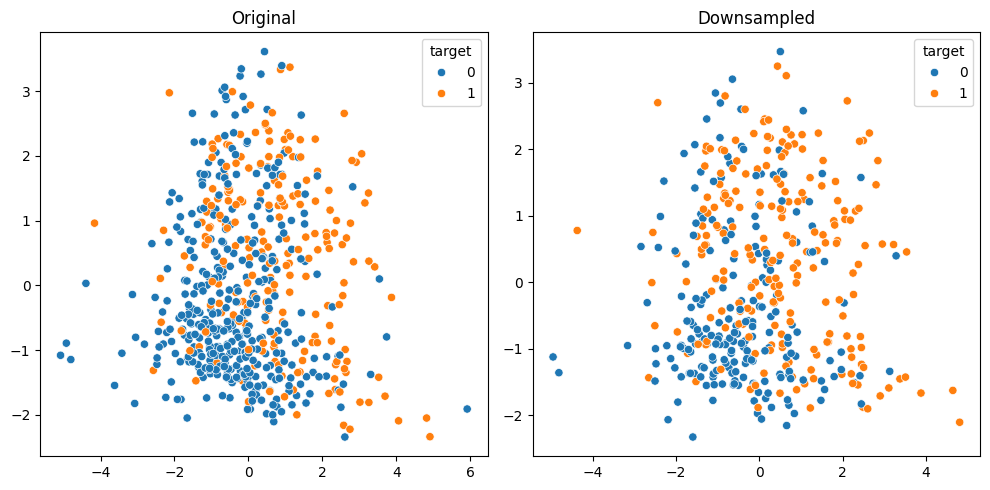

In [71]:
sample_downsampled = random_downsampler(df=ds_df, random_state=21)

print(f"Class instance count before downsampling: {Counter(ds_df['target'])}")
print(f"Class instance count after downsampling: {Counter(sample_downsampled['target'])}")
print("-" * 65)

# PLOTTING
datasets = [ds_df, sample_downsampled]
tmp_reduced = []
for data in datasets:
    scaler_tmp = StandardScaler()
    pca_tmp = PCA(n_components=2) # we just want to plot the data -- don't overthink it
    scaled_df = scaler_tmp.fit_transform(data.iloc[:, :-1])
    pca_reduced = pca_tmp.fit_transform(scaled_df)
    tmp_reduced.append(pca_reduced)

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "Downsampled"]
for i, ax in enumerate(axes):
    curr_data = tmp_reduced[i]
    sns.scatterplot(x=curr_data[:, 0], y=curr_data[:, 1], ax=ax, hue=datasets[i].iloc[:, -1])
    ax.set_title(names[i])
plt.tight_layout()

Visually, we can observe that some points in the original dataset aren't found in the downsampled version. At least in this projection, we can see that predicting a person with or without diabetes is quite tricky.

Though random undersampling is intuitive to understand, it's not the most systematic way to undersample. There are other methods, like TomekLinks, which can provide a more algorithmic way of downsampling. However, TomekLinks and its variants won't be actively discussed in this lecture. 

it would be tricky for the model to use PCA because there is no easy boundary cuz everything is gaussian

There are two drawbacks of random undersampling. On some level, we are introducing some form of basis. By undersampling, we are learning more on the minority class. There are actual meaningful patterns that we are just removing. We risk biasing our model to learn more on the minority class. This removes more of overfitting



### Random Oversampling

We have a drawback in random oversampling by:
We actually get points and then duplicate it. By duplicating the pattern, you actually risk overfitting the model. It does not add new information but rather replicates information.

Random oversampling takes advantage of resampling with replacement, sometimes indicated as [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) in some implementations. A consequence of random oversampling is that we also generate duplicated information in order to match the majority class count. We usually don't do random oversampling because of just copying.

In [72]:
 # take note that this is without our holdout set

os_df = X_Train.copy()
os_df['target'] = y_Train
os_df.reset_index(drop=True, inplace=True)

In [73]:
def random_oversampler(
    df: pd.DataFrame, random_state: Optional[int] = None, col: str = 'target', shuffle: bool = True
) -> pd.DataFrame:
    """Randomly oversample the minority class to match the majority class counts in a dataframe. 

    Parameters:
    -----------
    df (pd.DataFrame): The dataframe to upsample
    random_state (int): The random seed to use for reproducibility (default=None).
    col (str): The target column to use (default='target').
    shuffle (bool): Indicator if the rows of the returned dataframe would be randomized (default=True)

    Returns:
    --------
    final_df (pd.DataFrame): An oversampled version of the input df.
    """    

    # Get the label with the least count and use it to filter df
    value_counts = df[col].value_counts()
    minority_label = value_counts.idxmin()

    mask = df[col] == minority_label
    majority = df[~mask]
    minority = df[mask]

    # Since we're oversampling, we need to duplicate some rows to match the majority class
    # This is sampling with replacement.
    upsample = minority.sample(n=int(value_counts.max()), replace=True, random_state=random_state)
    final_df = pd.concat([majority, upsample])

    if shuffle:
        return final_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return final_df.reset_index(drop=True)

Class instance count before upsampling: Counter({0: 400, 1: 214})
Class instance count after upsampling: Counter({0: 400, 1: 400})
-----------------------------------------------------------------


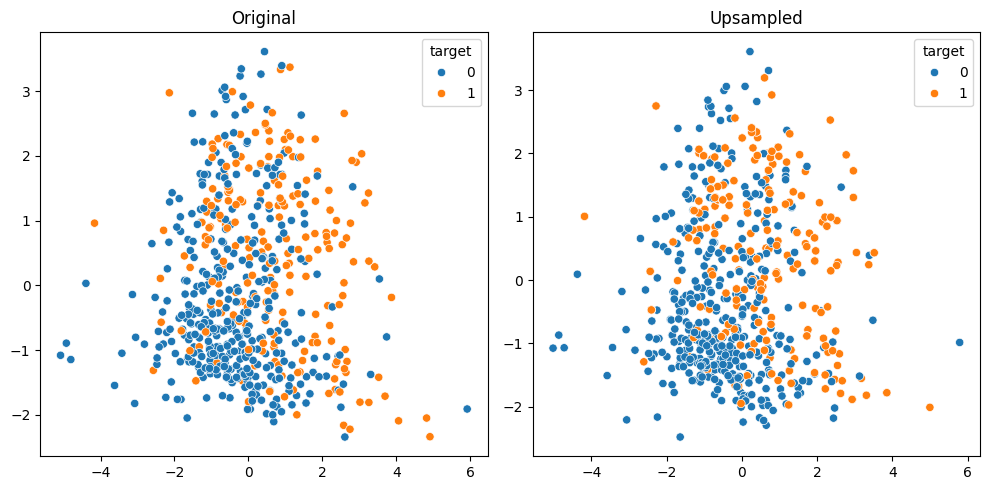

In [74]:
sample_upsampled = random_oversampler(df=os_df, random_state=21)

print(f"Class instance count before upsampling: {Counter(ds_df['target'])}")
print(f"Class instance count after upsampling: {Counter(sample_upsampled['target'])}")
print("-" * 65)

# PLOTTING
datasets = [os_df, sample_upsampled]
tmp_reduced = []
for data in datasets:
    scaler_tmp = StandardScaler()
    pca_tmp = PCA(n_components=2) # we just want to plot the data -- don't overthink it
    scaled_df = scaler_tmp.fit_transform(data.iloc[:, :-1])
    pca_reduced = pca_tmp.fit_transform(scaled_df)
    tmp_reduced.append(pca_reduced)

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "Upsampled"]
for i, ax in enumerate(axes):
    curr_data = tmp_reduced[i]
    sns.scatterplot(x=curr_data[:, 0], y=curr_data[:, 1], ax=ax, hue=datasets[i].iloc[:, -1])
    ax.set_title(names[i])
plt.tight_layout()

They just look a bit different because of the PCA. We do randomsampling first then we do PCA, thus it changes.

In [75]:
print(f"Number of duplicated rows: {sample_upsampled.duplicated().sum()}")

Number of duplicated rows: 213


### Introduction to `imblearn`

Implementing methods from scratch can be quite impractical in practice. For one, you need to test every implementation you make to ensure that it is correct. That means more low-impact work for you. Luckily, the methods we've discussed so far and our succeeding discussions have been created for us by `imblearn`. This library is a sister library of `scikit-learn` and it has a couple of built-in sampling methods for us to use. imblearn is specifically for class imbalance.

Let's try to convert our previous implementation by using this new library.

In [76]:
## run this if imblearn is not in your library
# !pip install imblearn --quiet

In [77]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [78]:
imb_df = X_Train.copy()
imb_df['target'] = y_Train
imb_df.reset_index(drop=True, inplace=True)

`RandomUnderSampler`

To do random undersampling, we simply call it from the `under_sampling` module of `imblearn`.

In [79]:
rus = RandomUnderSampler(random_state=92)

print(f"Class population before undersampling: {Counter(imb_df['target'])}")
print("-" * 65)

X_us, y_us = rus.fit_resample(imb_df.iloc[:, :-1], imb_df['target'])
print(f"Class population after undersampling: {Counter(y_us)}")

Class population before undersampling: Counter({0: 400, 1: 214})
-----------------------------------------------------------------
Class population after undersampling: Counter({0: 214, 1: 214})


`RandomOverSampler`

We do the same thing with random oversampling.

In [80]:
ros = RandomOverSampler(random_state=92)

print(f"Class population before oversampling: {Counter(imb_df['target'])}")
print("-" * 65)

X_os, y_os = ros.fit_resample(imb_df.iloc[:, :-1], imb_df['target'])
print(f"Class population after oversampling: {Counter(y_os)}")

Class population before oversampling: Counter({0: 400, 1: 214})
-----------------------------------------------------------------
Class population after oversampling: Counter({1: 400, 0: 400})


To check if the implementation uses bootstrapping, we can simply count the number of duplicated rows. Note that there can be some minor implementation differences between ours and the `imblearn` which is why it's more important to check if both implementations conform to the concept.

In [81]:
print(f"Number of duplicated rows: {X_os.duplicated().sum()}")

Number of duplicated rows: 186


### Effects of resampling methods to model performance

We haven't really checked to see the effects of these methods on our model at this point. Let's compare our two resampling methods with our baseline model. We'll be using the best parameters from our baseline moving forward. We'll also learn how to incorporate these methods into our pipeline.

YOu only want to resample on the train.

In [82]:
# Define parameters
seed = 31
C = 1.0
penalty = 'l1'

# Define model pipelines

## undersampling
us_model = Pipeline(
   [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, C=C, penalty=penalty, solver="saga"))
    ]
)

## oversampling
os_model = Pipeline(
   [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, C=C, penalty=penalty, solver="saga"))
    ]
)

We usually don't put our resampling methods within the `Pipeline` class, because we might run the risk of resampling on our validation and test sets. This means that if you place this pipeline into practice you might accidentally remove or create synthetic data. For now, let's focus on a simpler implementation. Just for the validation set, you test on real unseen data.

In [83]:
# Let's create resampled X_train samples

# Note that we're using X_train -- the one where we don't have the validation set anymore
rus = RandomUnderSampler(random_state=seed)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=seed)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

In [84]:
# Model Training
us_model.fit(X_train_us, y_train_us)
os_model.fit(X_train_os, y_train_os)

# Check on the validation set
us_preds = us_model.predict(X_val)
os_preds = os_model.predict(X_val)

In [85]:
print("Random Under Sampling Performance on the Validation Set:\n")
print(f"Training F1 Score: {f1_score(y_val, us_preds):.4f}")
print(classification_report(y_val, us_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, us_preds)))

print("=" * 65)

print("Random Over Sampling Performance on the Validation Set:\n")
print(f"Training F1 Score: {f1_score(y_val, os_preds):.4f}")
print(classification_report(y_val, os_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, os_preds)))


Random Under Sampling Performance on the Validation Set:

Training F1 Score: 0.6292
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        80
           1       0.61      0.65      0.63        43

    accuracy                           0.73       123
   macro avg       0.71      0.71      0.71       123
weighted avg       0.74      0.73      0.73       123

Validation Set Confusion Matrix:
     0   1
0  62  18
1  15  28
Random Over Sampling Performance on the Validation Set:

Training F1 Score: 0.6207
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        80
           1       0.61      0.63      0.62        43

    accuracy                           0.73       123
   macro avg       0.71      0.71      0.71       123
weighted avg       0.73      0.73      0.73       123

Validation Set Confusion Matrix:
     0   1
0  63  17
1  16  27


### Post Mortem

Now we've already discussed the two standard methods and (hopefully) understand how they work. We do find that oversampling, compared to undersampling, tends to retain the original information we have in our data. However, if we simply bootstrap our data we would risk overfitting and we may force our model to learn a distribution that isn't realistic. 

What if we can try to improve random oversampling? Is there a way to be more data-driven and systematic in creating synthetic samples? These are the same questions people asked which lead to the development of SMOTE. If youre dataset is more severely unbalanced, then you will see a big difference. From these performances, what is this model trying to tell you about the data (this is what we should learn)? Depending on the class distribution, you could choose which one you want. Macro-average is usually for more than two.

## SMOTE

We want to find improvements for oversampling by moving away from bootstrapping. What if we can take advantage of what we've learned from ML1 on nearest neighbors?

<p align="center">
  <img src="figures/smote.png" style="width:90%;"><br>
  <em>Figure 1: SMOTE Visualization</em>
</p>

---

SMOTE has a relatively simple algorithm. Understanding the algorithm will help you understand the succeeding variants of SMOTE.

**Algorithm**
1. Compute the $k$-nearest neighbors of the minority class using the Euclidean distance;
2. Select a random neighbor $j$
3. Generate a synthetic sample following this formula:

\begin{equation*}
x_{\text{new}} = x_i + \alpha(x_j - x_i),
\end{equation*}

where $x_i$ is the current point, $x_j$ is the neighbor point, and $\alpha \in \mathbf{U}(0, 1)$ whose value is randomly selected.

Step 3 is the reason why SMOTE is often visuallized with a straight line: you get two points that, draw a straight line between them, and randomly create a point within that line. The idea of doing this is to create a synthetic point that isn't a duplicated and it *should* be found within the same location as its class. By doing this we *hope* that the distribution of the minority class is preserved. 

---

Let's try to implement it now using `imblearn`.

In [86]:
from imblearn.over_sampling import SMOTE

In [87]:
seed = 31
C = 1.0
penalty = 'l1'

smote_model = Pipeline(
   [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, C=C, penalty=penalty, solver="saga"))
    ]
)

In [88]:
# Let's create resampled X_train samples

smote = SMOTE(random_state=seed, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [89]:
smote_model.fit(X_train_smote, y_train_smote)
smote_preds = smote_model.predict(X_val)

In [90]:
print("SMOTE Sampling Performance on the Validation Set:\n")
print(classification_report(y_val, smote_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, smote_preds)))

SMOTE Sampling Performance on the Validation Set:

              precision    recall  f1-score   support

           0       0.79      0.78      0.78        80
           1       0.60      0.63      0.61        43

    accuracy                           0.72       123
   macro avg       0.70      0.70      0.70       123
weighted avg       0.73      0.72      0.72       123

Validation Set Confusion Matrix:
     0   1
0  62  18
1  16  27


**Let's try to be skeptical for a minute. Did SMOTE really avoid creating synthetic data?**

In [91]:
print(f"Number of duplicated rows: {X_train_smote.duplicated().sum()}")

Number of duplicated rows: 0


**Well, yeah.**

Let's visualize our new dataset and see what happened. 

Class instance count before SMOTE: Counter({0: 320, 1: 171})
Class instance count after SMOTE: Counter({0: 320, 1: 320})
-----------------------------------------------------------------


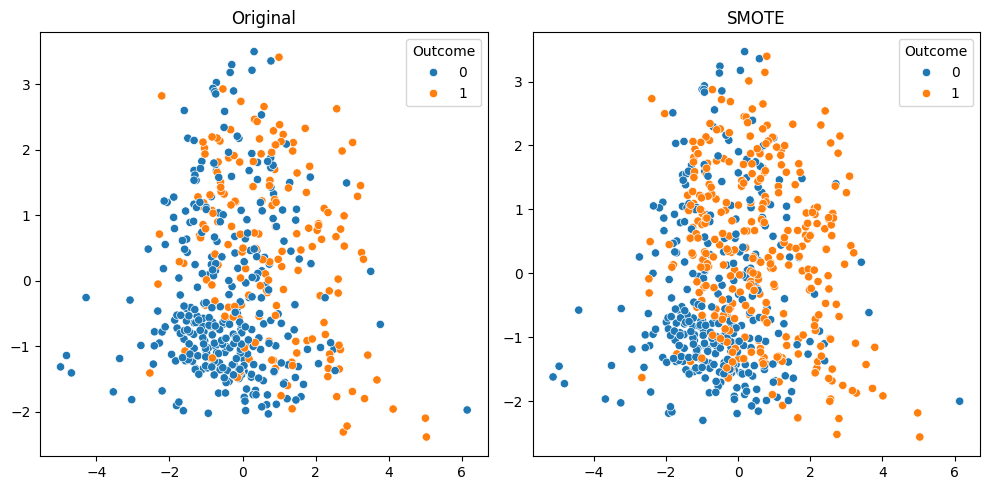

In [92]:
print(f"Class instance count before SMOTE: {Counter(y_train)}")
print(f"Class instance count after SMOTE: {Counter(y_train_smote)}")
print("-" * 65)

# PLOTTING
datasets = [X_train, X_train_smote]
tmp_reduced = []
for data in datasets:
    scaler_tmp = StandardScaler()
    pca_tmp = PCA(n_components=2) # we just want to plot the data -- don't overthink it
    scaled_df = scaler_tmp.fit_transform(data)
    pca_reduced = pca_tmp.fit_transform(scaled_df)
    tmp_reduced.append(pca_reduced)

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "SMOTE"]
targets = [y_train, y_train_smote]
for i, ax in enumerate(axes):
    curr_data = tmp_reduced[i]
    sns.scatterplot(x=curr_data[:, 0], y=curr_data[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

Visually, we find that the SMOTE method generates denser areas compared to our original and randomly oversampled dataset. This is expected, because we're trying to generate synthetic data **in-between two points**. 

### Tuning SMOTE

Much like any part of a pipeline, we can try to tune our SMOTE algorithm. Currently, there is no standard for finding the best parameters but the most common way to do so is through grid search. Let's implement the same tuning strategy as before, but now we'll be tuning SMOTE only. Our goal is to simply understand how to implement tuning and how to view our results. You can't just tune SMOTE directly since it needs to be in relation to the score/metric done by modelling.

In [93]:
from imblearn.pipeline import Pipeline as imb_pipeline  # We need this to make SMOTE compatible to scikit-learn modules

In [94]:
seed = 31
C = 1.0
penalty = 'l1'

smote_tuning_pipe = imb_pipeline(
    [
        ("smote", SMOTE(random_state=seed)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, C=C, penalty=penalty, solver="saga"))
    ]
)

params = dict(smote__k_neighbors=range(1, 11))

# Model training
skf = StratifiedKFold(n_splits=5, random_state=32, shuffle=True)

rcv = RandomizedSearchCV(smote_tuning_pipe, params, random_state=0, scoring='f1', cv=skf)
search = rcv.fit(X_train, y_train)

best_smote_params = search.best_params_
print(best_smote_params)

{'smote__k_neighbors': 3}


In [95]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_smote__k_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005983,0.001722,0.001959,0.000442,1,{'smote__k_neighbors': 1},0.575342,0.701299,0.701299,0.649351,0.631579,0.651774,0.047246,5
1,0.004174,0.000928,0.001523,0.000269,2,{'smote__k_neighbors': 2},0.527778,0.683544,0.701299,0.648649,0.657895,0.643833,0.060941,7
2,0.007423,0.003098,0.001477,0.000159,3,{'smote__k_neighbors': 3},0.547945,0.710526,0.683544,0.692308,0.666667,0.660198,0.057882,1
3,0.003268,0.000154,0.001265,0.000153,4,{'smote__k_neighbors': 4},0.520548,0.702703,0.684211,0.640000,0.649351,0.639362,0.063625,10
4,0.003315,0.000375,0.001200,0.000070,5,{'smote__k_neighbors': 5},0.547945,0.693333,0.701299,0.666667,0.657895,0.653428,0.055147,3
5,0.003421,0.000518,0.001250,0.000087,6,{'smote__k_neighbors': 6},0.535211,0.692308,0.701299,0.640000,0.657895,0.645342,0.059417,6
6,0.003189,0.000098,0.001194,0.000045,7,{'smote__k_neighbors': 7},0.547945,0.702703,0.692308,0.666667,0.649351,0.651795,0.055217,4
7,0.003144,0.000119,0.001177,0.000031,8,{'smote__k_neighbors': 8},0.567568,0.692308,0.683544,0.657534,0.684211,0.657033,0.046239,2
8,0.003342,0.000297,0.001247,0.000125,9,{'smote__k_neighbors': 9},0.547945,0.693333,0.683544,0.647887,0.640000,0.642542,0.051468,9
9,0.003202,0.000077,0.001215,0.000048,10,{'smote__k_neighbors': 10},0.540541,0.701299,0.666667,0.657534,0.649351,0.643078,0.054237,8


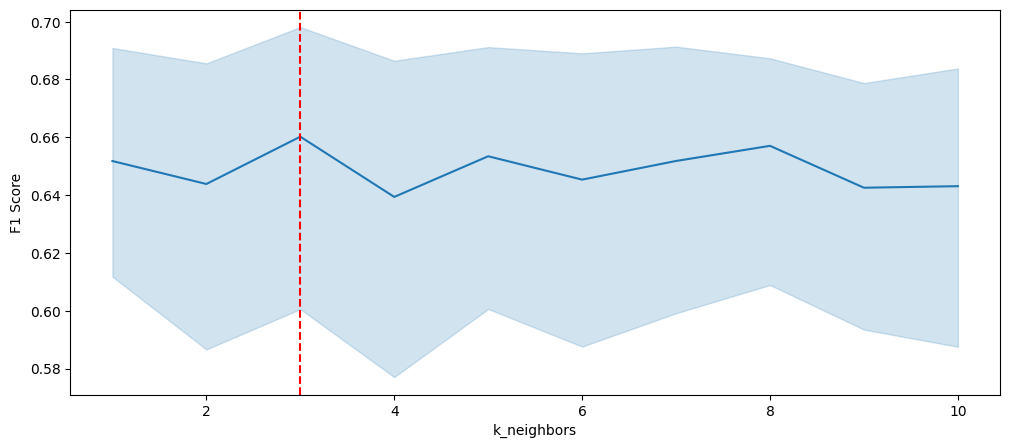

In [96]:
cv_scores = { key.split("_")[0] : value for key, value in search.cv_results_.items() if "split" in key }
train_scores = pd.DataFrame(cv_scores)
train_scores["k"] = range(1, 11)

flat_df = train_scores.melt(id_vars="k")

plt.figure(figsize=(12, 5))
sns.lineplot(data=flat_df, x="k", y="value")
plt.axvline(3, linestyle="--", color="red", alpha=1)
plt.ylabel("F1 Score")
plt.xlabel("k_neighbors")
plt.show()

We're able to find through a simple tuning strategy that the best $k$ for SMOTE is 3. This is corroborated by the fact that for each CV split, $k=3$ generates the highest F1 score on average. The confidence intervals provide us insight into how high or low we can expect the F1 score to reach for the entire pipeline.

## SMOTE-NC and SMOTE-N

The original SMOTE model does really well with purely numerical data. We often deal with categorical data in reality; wether they are mixed with non-categorical data or we have purely categorical data. 

To streamline the conversation, let's begin with SMOTE-NC. A variant of SMOTE that would help us handle data that has both categorical and numerical information. We'll then see SMOTE-N, a variant that works only for categorical data. To further see the applications of both these methods, we'll try to test them on manually binned features which is a common way of incorporating group information.

### SMOTE-NC

SMOTE-NC (**S**ynthetic **M**inority **O**versampling **TE**chnique - **N**ominal & **C**ontinuous) is a variant of SMOTE that can operate on both categorical and continuous information. Previously we treated all features in our dataframe as continuous features. However, there may be cases where we need to treat some features as categorical or that we have some categorical features mixed in. 

---
The algorithm is quite similar to the original SMOTE, but with two main differences.

**Algorithm:**
1. Compute the median of standard deviations of all continuous features for the minority class. This median serves as a penalty term when nominal features are different;
2. Find the $k$-nearest neighbors using the Euclidean distance. If the nominal feature between a sample and its potential nearest neighbor, the computed median from (1) will be added to the distance computation. The median of standard deviations, denoted as $\tau = \text{med}(\{\sigma_m :m \in C\})$ where feature $m$ is part of all continuous features $C$, will be added for every nominal feature the sample and its potential nearest neighbor are different. Succinctly,

\begin{equation*}
d(x_i, x_j) = \sqrt{\sum_{m\in C}(x_{i,m} - x_{j, m})^2 + \tau^2\sum_{m\in N}\mathbf{1}_{i \neq j}},
\end{equation*}

where $\sum_{m\in C}(x_{i,m} - x_{j, m})^2$ is the sum of squared differences for each feature $m$ in all continuous features $C$, between our sample point $i$ and potential neighbor $j$. We square the median of standard deviations $\tau$ within our distance computation because we want to ensure that they are on the same scale. Moreover, we only include $\tau$ if the two points have a difference on nominal features $N$.

> For reference the $\mathbf{1}_{i \neq j}$ is called the [indicator function](https://en.wikipedia.org/wiki/Indicator_function) which says that the value is 1 if the feature values of $i$ and $j$ are different, 0 otherwise.

3. Generate the new synthetic point. For continuous variables $C$, we do the same operation as the standard SMOTE algorithm. The nominal, $N$, feature is the mode of the $k$-nearest neighbors for that feature. Essentially,

\begin{align*}
x_{\text{new},m} &= x_{i,m} + \alpha(x_{j,m} - x_{i,m}), \ m \in C \\
x_{\text{new},m} &= \text{mode}(\{x_{j,m} : m \in N \ \forall \ j \in k_{nn}\})
\end{align*}

---


SMOTE-NC tries to encode chosen nominal features using one-hot encoding by default. The other common encoding is using an `OrdinalEncoder`. Let's try to implement this algorithm.

In [97]:
from imblearn.over_sampling import SMOTENC

In [98]:
seed = 31
C = 1.0
penalty = 'l1'

unbin_smotenc_model = Pipeline(
   [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, C=C, penalty=penalty, solver="saga"))
    ]
)

In [99]:
smotenc_unbin = SMOTENC(categorical_features=["BMI", "Age"], k_neighbors=5, random_state=seed)
X_train_smotenc_unbin, y_train_smotenc_unbin = smotenc_unbin.fit_resample(X_train, y_train)

In [100]:
unbin_smotenc_model.fit(X_train_smotenc_unbin, y_train_smotenc_unbin)
smotenc_unbin_preds = unbin_smotenc_model.predict(X_val)

In [101]:
print("SMOTE Sampling Performance on the Validation Set:\n")
print(classification_report(y_val, smotenc_unbin_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, smotenc_unbin_preds)))

SMOTE Sampling Performance on the Validation Set:

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        80
           1       0.60      0.65      0.62        43

    accuracy                           0.72       123
   macro avg       0.70      0.71      0.70       123
weighted avg       0.73      0.72      0.73       123

Validation Set Confusion Matrix:
     0   1
0  61  19
1  15  28


Class instance count before SMOTE-NC: Counter({0: 320, 1: 171})
Class instance count after SMOTE-NC: Counter({0: 320, 1: 320})
-----------------------------------------------------------------


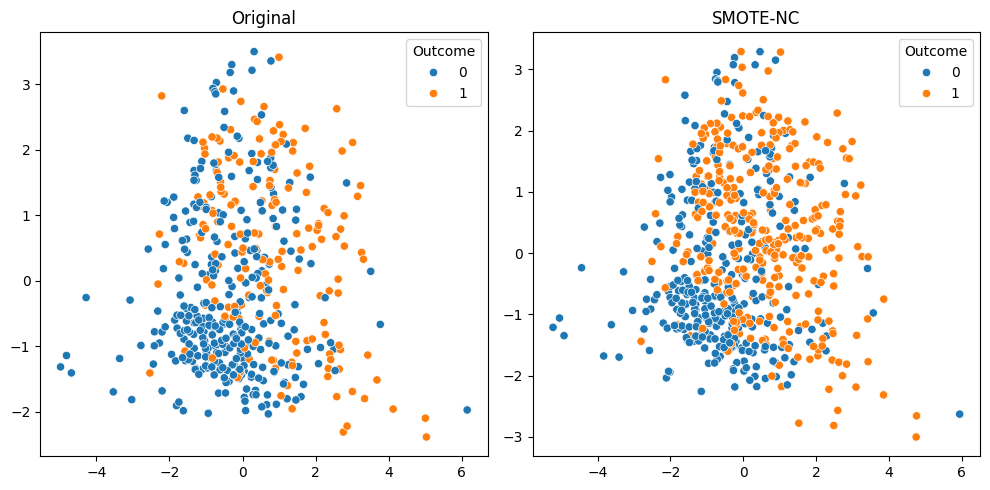

In [102]:
print(f"Class instance count before SMOTE-NC: {Counter(y_train)}")
print(f"Class instance count after SMOTE-NC: {Counter(y_train_smotenc_unbin)}")
print("-" * 65)

# PLOTTING
datasets = [X_train, X_train_smotenc_unbin]
tmp_reduced = []
for data in datasets:
    scaler_tmp = StandardScaler()
    pca_tmp = PCA(n_components=2) # we just want to plot the data -- don't overthink it
    scaled_df = scaler_tmp.fit_transform(data)
    pca_reduced = pca_tmp.fit_transform(scaled_df)
    tmp_reduced.append(pca_reduced)

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "SMOTE-NC"]
targets = [y_train, y_train_smotenc_unbin]
for i, ax in enumerate(axes):
    curr_data = tmp_reduced[i]
    sns.scatterplot(x=curr_data[:, 0], y=curr_data[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

### SMOTE-N

We've seen how we can modify SMOTE to work for a combination of numerical and categorical data. What if we have only categorical information? 

When looking at SMOTE-NC, we find that the continuous variables are a key part of finding the nearest neighbors. So how do we remove our reliance to those variables? From the original paper [1], the authors mentioned to use a different distance metric known as the [value difference metric](https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.pairwise.ValueDifferenceMetric.html). 

Given two vectors $X$ and $Y$, we define their distance for $F$ features, denoted as $\Delta(X,Y)$, as

\begin{equation*}
\Delta(X,Y) = \sum_{f=1}^F \delta(X_f, Y_f)^r,
\end{equation*}

where $r$ is some constant usually set to 1 (Manhattan) or 2 (Euclidean). $\delta(X_f, Y_f)$ is distance between two corresponding feature values for all classes $C$ defined as

\begin{equation*}
\delta(x, y) = \sum_{c=1}^C \left| P(c|x_f) - P(c|y_f)  \right|^k,
\end{equation*}

where $c$ is the $i$-th class in our dataset, $P(c|x_f)$ is the conditional probability that the output class is $c$ given that the feature value $f$ is $x$. For SMOTE-N, we usually set the constant $k$ to 1.

---

With that out of the way, let's look at the algorithm for SMOTE-N.

**Algorithm:**
1. Compute the $k$-nearest neighbors of the minority class using the value difference metric;
2. Choose a random neighbor $j$;
3. Generate new feature values by taking the mode of each feature from its $k$-nearest neighbors.

---

Generally, SMOTE-N is quite similar to SMOTE but it changes the metric to make it usable for categorical features. Compared to SMOTE-NC, the value difference metric removes the need for SMOTE-N to use continuous variables. 

Much like SMOTE-NC you can choose the encoding method for categorical features. In contrast to SMOTE-NC, SMOTE-N uses the `OrdinalEncoder` by default.

Let's see how to implement this algorithm.

In [103]:
from imblearn.over_sampling import SMOTEN

In [104]:
seed = 31
C = 1.0
penalty = 'l1'

unbin_smoten_model = Pipeline(
   [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, C=C, penalty=penalty, solver="saga"))
    ]
)

In [105]:
smoten_unbin = SMOTEN(k_neighbors=5, random_state=seed)
X_train_smoten_unbin, y_train_smoten_unbin = smoten_unbin.fit_resample(X_train, y_train)

In [106]:
unbin_smoten_model.fit(X_train_smoten_unbin, y_train_smoten_unbin)
smoten_unbin_preds = unbin_smoten_model.predict(X_val)

In [107]:
print("SMOTE-N Sampling Performance on the Validation Set:\n")
print(classification_report(y_val, smoten_unbin_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, smoten_unbin_preds)))

SMOTE-N Sampling Performance on the Validation Set:

              precision    recall  f1-score   support

           0       0.78      0.66      0.72        80
           1       0.51      0.65      0.57        43

    accuracy                           0.66       123
   macro avg       0.64      0.66      0.64       123
weighted avg       0.68      0.66      0.67       123

Validation Set Confusion Matrix:
     0   1
0  53  27
1  15  28


Class instance count before SMOTE-N: Counter({0: 320, 1: 171})
Class instance count after SMOTE-N: Counter({0: 320, 1: 320})
-----------------------------------------------------------------


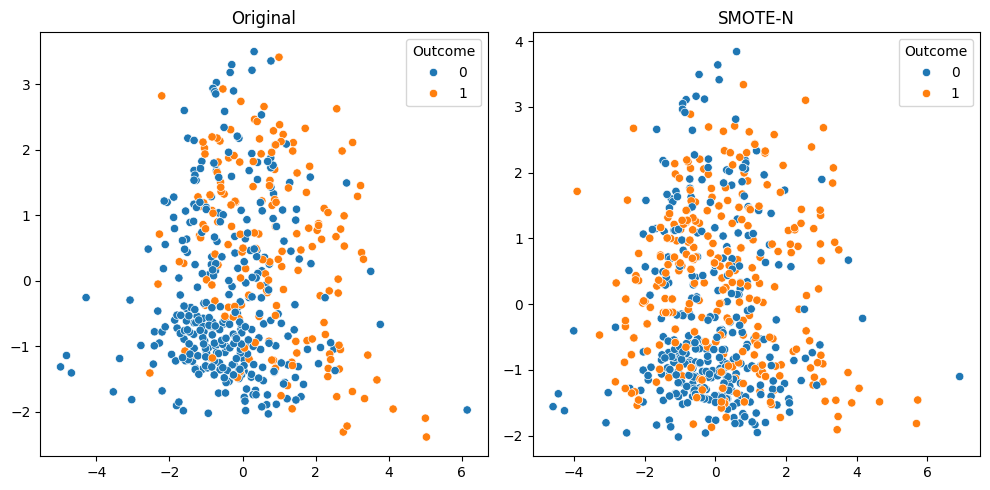

In [108]:
print(f"Class instance count before SMOTE-N: {Counter(y_train)}")
print(f"Class instance count after SMOTE-N: {Counter(y_train_smoten_unbin)}")
print("-" * 65)

# PLOTTING
datasets = [X_train, X_train_smoten_unbin]
tmp_reduced = []
for data in datasets:
    scaler_tmp = StandardScaler()
    pca_tmp = PCA(n_components=2) # we just want to plot the data -- don't overthink it
    scaled_df = scaler_tmp.fit_transform(data)
    pca_reduced = pca_tmp.fit_transform(scaled_df)
    tmp_reduced.append(pca_reduced)

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "SMOTE-N"]
targets = [y_train, y_train_smoten_unbin]
for i, ax in enumerate(axes):
    curr_data = tmp_reduced[i]
    sns.scatterplot(x=curr_data[:, 0], y=curr_data[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

### Binning features

Let's see another common implementation when dealing with real-world data. In some cases, you may be inclined to bin features especially if there is a known grouping. We can define different bins for at least two of our features, namely, `Age` and `BMI`. There is a generally accepted binning that we can use; you can find it [here](https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html). For `Age` we can define arbitrary groups for now. 

Once we've created our bins, we can `drop` the original features and see how our SMOTE models hold up. 

In [109]:
X_Train_c = X_Train.copy()
y_Train_c = y_Train.copy()

# Age bins
X_Train_c["Age0-14"]   = np.where(X_Train_c["Age"] <= 14, 1, 0)
X_Train_c["Age15-24"]  = np.where((X_Train_c["Age"] >= 15) & (X_Train_c["Age"] <= 24), 1, 0)
X_Train_c["Age25-50"]  = np.where((X_Train_c["Age"] >= 25) & (X_Train_c["Age"] <= 50), 1, 0)
X_Train_c["Age50-65"]  = np.where((X_Train_c["Age"] >= 51) & (X_Train_c["Age"] <= 65), 1, 0)
X_Train_c["Age65+"]    = np.where(X_Train_c["Age"] > 65, 1, 0)

X_Train_c.drop(columns=["Age"], inplace=True)

# BMI bins
X_Train_c["BMI_under18.5"] = np.where(X_Train_c["BMI"] < 18.5, 1, 0)
X_Train_c["BMI18.5-24"]    = np.where((X_Train_c["BMI"] >= 18.5) & (X_Train_c["BMI"] < 25), 1, 0)
X_Train_c["BMI25-30"]      = np.where((X_Train_c["BMI"] >= 25) & (X_Train_c["BMI"] < 30), 1, 0)
X_Train_c["BMI30-35"]      = np.where((X_Train_c["BMI"] >= 30) & (X_Train_c["BMI"] < 35), 1, 0)
X_Train_c["BMI35-40"]      = np.where((X_Train_c["BMI"] >= 35) & (X_Train_c["BMI"] < 40), 1, 0)
X_Train_c["BMI40+"]        = np.where(X_Train_c["BMI"] >= 40, 1, 0)

X_Train_c.drop(columns=["BMI"], inplace=True)

# Display
display(X_Train_c.head())


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,Age0-14,Age15-24,Age25-50,Age50-65,Age65+,BMI_under18.5,BMI18.5-24,BMI25-30,BMI30-35,BMI35-40,BMI40+
22,7,196,90,0,0,0.451,0,0,1,0,0,0,0,0,0,1,0
497,2,81,72,15,76,0.547,0,0,1,0,0,0,0,0,1,0,0
395,2,127,58,24,275,1.600,0,0,1,0,0,0,0,1,0,0,0
381,0,105,68,22,0,0.236,0,1,0,0,0,0,1,0,0,0,0
258,1,193,50,16,375,0.655,0,1,0,0,0,0,0,1,0,0,0


---
#### Coding interlude: categorical encoders

Since we're trying to use binned features, what would the dataframe look like after doing `OneHotEncoding` and `OrdinalEncoding` on these features. Let's do a quick look to better understand what SMOTE-NC and SMOTE-N sees.


In [110]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [111]:
categorical = [x for x in X_Train_c.columns if "Age" in x or "BMI" in x]

bins = X_Train_c[categorical]

ohe = OneHotEncoder()
ore = OrdinalEncoder()

ohe_f = ohe.fit_transform(bins)
ore_f = ore.fit_transform(bins)

In [112]:
ohe_feats = ohe.get_feature_names_out()

print("One-Hot Encoded Results:\n")
print(f"# Original columns: {len(categorical)}\n# OHE columns: {len(ohe_feats)}")
print("-" * 65)
print("Feature Names:\n", ohe_feats)
print("=" * 65)


One-Hot Encoded Results:

# Original columns: 11
# OHE columns: 21
-----------------------------------------------------------------
Feature Names:
 ['Age0-14_0' 'Age15-24_0' 'Age15-24_1' 'Age25-50_0' 'Age25-50_1'
 'Age50-65_0' 'Age50-65_1' 'Age65+_0' 'Age65+_1' 'BMI_under18.5_0'
 'BMI_under18.5_1' 'BMI18.5-24_0' 'BMI18.5-24_1' 'BMI25-30_0' 'BMI25-30_1'
 'BMI30-35_0' 'BMI30-35_1' 'BMI35-40_0' 'BMI35-40_1' 'BMI40+_0' 'BMI40+_1']


In [113]:
ore_feats = ore.get_feature_names_out()

print("Ordinal Encoded Results:\n")
print(f"# Original columns: {len(categorical)}\n# OHE columns: {len(ore_feats)}")
print("-" * 65)
print("Feature Names:\n", ore_feats)
print("=" * 65)


Ordinal Encoded Results:

# Original columns: 11
# OHE columns: 11
-----------------------------------------------------------------
Feature Names:
 ['Age0-14' 'Age15-24' 'Age25-50' 'Age50-65' 'Age65+' 'BMI_under18.5'
 'BMI18.5-24' 'BMI25-30' 'BMI30-35' 'BMI35-40' 'BMI40+']


Because our binned features are already encoded, we can use the `OrdinalEncoder` to preserve the information we want. Note that this may only be true for this case and, at least for binned features like these, `OrdinalEncoder` can be proven useful.

---

#### SMOTE-NC with Binned Features

In [114]:
seed = 31
C = 1.0
penalty = 'l1'

bin_smotenc_model = Pipeline(
   [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, C=C, penalty=penalty, solver="saga"))
    ]
)

In [115]:
# Create new train-val splits
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
    X_Train_c, y_Train_c, test_size=0.2, random_state=0, stratify=y_Train_c
)

categorical = [x for x in X_Train_c.columns if "Age" in x or "BMI" in x]

smotenc_bin = SMOTENC(categorical_features=categorical, k_neighbors=5, random_state=seed)
X_train_smotenc_bin, y_train_smotenc_bin = smotenc_bin.fit_resample(X_train_c, y_train_c)

In [116]:
bin_smotenc_model.fit(X_train_smotenc_bin, y_train_smotenc_bin)
smotenc_preds_bin = bin_smotenc_model.predict(X_val_c)

In [117]:
print("SMOTE-NC Sampling Performance on the Validation Set:\n")
print(classification_report(y_val_c, smotenc_preds_bin))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val_c, smotenc_preds_bin)))

SMOTE-NC Sampling Performance on the Validation Set:

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        80
           1       0.67      0.77      0.72        43

    accuracy                           0.79       123
   macro avg       0.77      0.78      0.77       123
weighted avg       0.80      0.79      0.79       123

Validation Set Confusion Matrix:
     0   1
0  64  16
1  10  33


Class instance count before SMOTE-N: Counter({0: 320, 1: 171})
Class instance count after SMOTE-N: Counter({0: 320, 1: 320})
-----------------------------------------------------------------


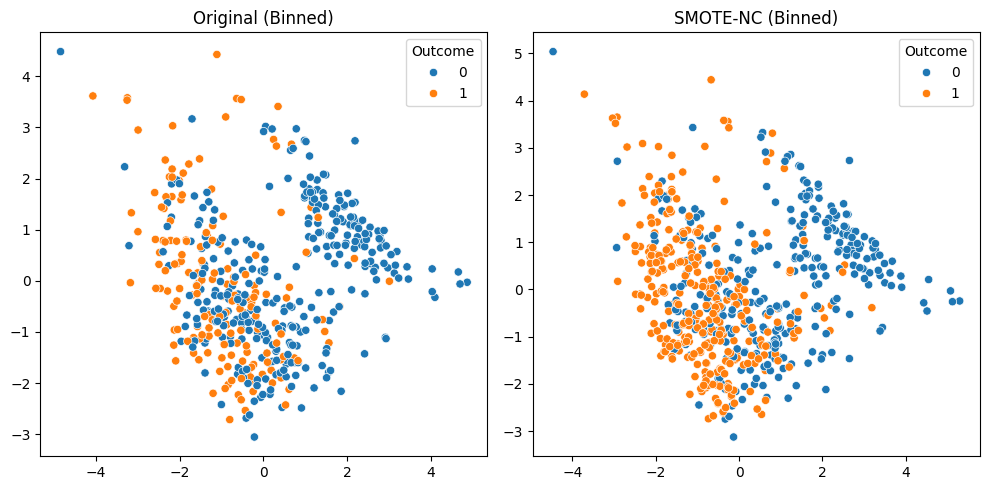

In [118]:
print(f"Class instance count before SMOTE-N: {Counter(y_train_c)}")
print(f"Class instance count after SMOTE-N: {Counter(y_train_smotenc_bin)}")
print("-" * 65)

# PLOTTING
datasets = [X_train_c, X_train_smotenc_bin]
tmp_reduced = []
for data in datasets:
    scaler_tmp = StandardScaler()
    pca_tmp = PCA(n_components=2) # we just want to plot the data -- don't overthink it
    scaled_df = scaler_tmp.fit_transform(data)
    pca_reduced = pca_tmp.fit_transform(scaled_df)
    tmp_reduced.append(pca_reduced)

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original (Binned)", "SMOTE-NC (Binned)"]
targets = [y_train_c, y_train_smotenc_bin]
for i, ax in enumerate(axes):
    curr_data = tmp_reduced[i]
    sns.scatterplot(x=curr_data[:, 0], y=curr_data[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

#### SMOTE-N with Binned Features

In [119]:
seed = 31
C = 1.0
penalty = 'l1'

binned_smoten_model = Pipeline(
   [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, C=C, penalty=penalty, solver="saga"))
    ]
)

In [120]:
smoten_bin = SMOTEN(k_neighbors=5, random_state=seed)
X_train_smoten_bin, y_train_smoten_bin = smoten_bin.fit_resample(X_train_c, y_train_c)

binned_smoten_model.fit(X_train_smoten_bin, y_train_smoten_bin)
smoten_preds_bin = binned_smoten_model.predict(X_val_c)

In [121]:
print("SMOTE-N Sampling Performance on the Validation Set:\n")
print(classification_report(y_val_c, smoten_preds_bin))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val_c, smoten_preds_bin)))

SMOTE-N Sampling Performance on the Validation Set:

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        80
           1       0.64      0.65      0.64        43

    accuracy                           0.75       123
   macro avg       0.72      0.73      0.72       123
weighted avg       0.75      0.75      0.75       123

Validation Set Confusion Matrix:
     0   1
0  64  16
1  15  28


Class instance count before SMOTE-N: Counter({0: 320, 1: 171})
Class instance count after SMOTE-N: Counter({0: 320, 1: 320})
-----------------------------------------------------------------


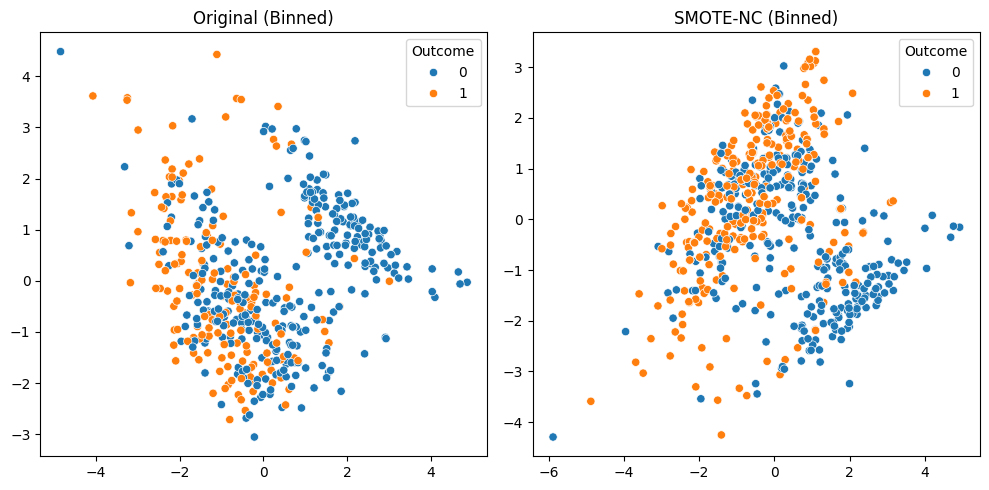

In [122]:
print(f"Class instance count before SMOTE-N: {Counter(y_train_c)}")
print(f"Class instance count after SMOTE-N: {Counter(y_train_smoten_bin)}")
print("-" * 65)

# PLOTTING
datasets = [X_train_c, X_train_smoten_bin]
tmp_reduced = []
for data in datasets:
    scaler_tmp = StandardScaler()
    pca_tmp = PCA(n_components=2) # we just want to plot the data -- don't overthink it
    scaled_df = scaler_tmp.fit_transform(data)
    pca_reduced = pca_tmp.fit_transform(scaled_df)
    tmp_reduced.append(pca_reduced)

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original (Binned)", "SMOTE-NC (Binned)"]
targets = [y_train_c, y_train_smoten_bin]
for i, ax in enumerate(axes):
    curr_data = tmp_reduced[i]
    sns.scatterplot(x=curr_data[:, 0], y=curr_data[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

### Post Mortem

We've seen how effective and flexible SMOTE and its variants can be. We saw that it's actually a pretty huge step-up from simple bootstrapping. However, there is one glaring issue with SMOTE: it generates synthetic data indiscriminately. What we mean by this is that SMOTE may not necessarily create new samples of data that are harder to learn.

Realistically, we can expect data to misbehave -- some data would be outliers or maybe they lie on the intersection of another class. In these cases, SMOTE may not actually help us create examples that are harder for our model to learn. But let's step back, why do we need to do that in the first place?


## ADASYN

**ADA**ptive **SYN**thetic (ADASYN) sampling is another oversampling approach that improves on SMOTE. One of the main reasons why this algorithm is created is to address the limitations of SMOTE on the data generation. Specifically, it can adapt its syntehtic generation based on local neighborhoods. 


<p align="center">
  <img src="figures/adasyn.png" style="width:70%;"><br>
  <em>Figure 2: ADASYN Visualization from <a link="https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn">here</a></em>
</p>


---

Let's try to understand the algorithm as much as we can. We define $m_s$ as the number of number of minority class samples and $m_l$ as the number of majority class samples. Then the procedure are as follows:

**Algorithm:**
1. Calculate the degree of class imbalance in the whole dataset $$d = \frac{m_s}{m_l}, $$ where $d\in (0, 1]$;
2. Compute the number of synthetic data examples that need to be generated for the minority class: $$G = (m_l - m_s) \times \beta,$$ where $\beta \in [0, 1]$ is a parameter used to specify the desired balance level. $\beta = 1$ means a fully balanced data set.
3. For each example $x_i \in \text{minority class}$, find the $k$-nearest neighbors based on the Euclidean distance (similar to SMOTE) and then calculate the ratio $r_i$ defined as $$r_i = \frac{\Delta_i}{k}, \ \ i = 1, \dots, m_s$$ where $\Delta_i$ is the number of samples in the $k$-nearest neighbors of $x_i$ that belong to the majority class, therefore $r_i \in [0, 1]$.
4. Normalize $r_i$ according to $$\hat{r}_i = \frac{r_i}{\sum_{i=1}^{m_s}r_i}$$ so that $\hat{r}_i$ is a density distribution $\left(\sum_i \hat{r}_i = 1 \right)$
5. Calculate the number of synthetic data to generate for each neighborhood $g_i$: $$g_i = G\hat{r}_i$$
6. For each neighborhood $g_i$, take the minority sample $x_i$ and a random minority neighbor $x_{zi}$. Then generate the synthetic point following the formula $$x_{\text{new}} = x_i + \alpha(x_{zi} - x_i),$$ where $\alpha \in \mathbf{U}(0, 1)$ whose value is randomly selected.

---

Based from the ADASYN algorithm, we do find that it shares similarities with the SMOTE algorithm. A notable difference is on how it tries to adapt or focus on specific areas to generate new data from. This ties in as to why it has the "adaptive" aspect in its name. 

Let's see how to implement this algorithm.

In [123]:
from imblearn.over_sampling import ADASYN

In [124]:
seed = 31
C = 1.0
penalty = 'l1'

adasyn_model = Pipeline(
   [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, C=C, penalty=penalty, solver="saga"))
    ]
)

In [125]:
# Let's create resampled X_train samples

adasyn = ADASYN(random_state=seed, n_neighbors=5, sampling_strategy="minority")
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

In [126]:
adasyn_model.fit(X_train_adasyn, y_train_adasyn)
adasyn_preds = adasyn_model.predict(X_val)

In [127]:
print("ADASYN Sampling Performance on the Validation Set:\n")
print(classification_report(y_val, adasyn_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, adasyn_preds)))

ADASYN Sampling Performance on the Validation Set:

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        80
           1       0.60      0.65      0.62        43

    accuracy                           0.72       123
   macro avg       0.70      0.71      0.70       123
weighted avg       0.73      0.72      0.73       123

Validation Set Confusion Matrix:
     0   1
0  61  19
1  15  28


Class instance count before ADASYN: Counter({0: 320, 1: 171})
Class instance count after ADASYN: Counter({0: 320, 1: 303})
-----------------------------------------------------------------


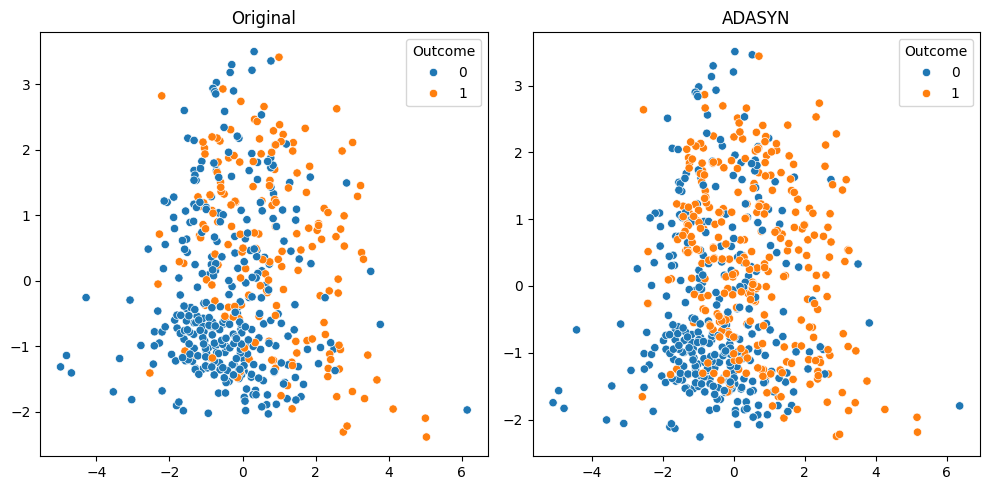

In [128]:
print(f"Class instance count before ADASYN: {Counter(y_train)}")
print(f"Class instance count after ADASYN: {Counter(y_train_adasyn)}")
print("-" * 65)

# PLOTTING
datasets = [X_train, X_train_adasyn]
tmp_reduced = []
for data in datasets:
    scaler_tmp = StandardScaler()
    pca_tmp = PCA(n_components=2) # we just want to plot the data -- don't overthink it
    scaled_df = scaler_tmp.fit_transform(data)
    pca_reduced = pca_tmp.fit_transform(scaled_df)
    tmp_reduced.append(pca_reduced)

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "ADASYN"]
targets = [y_train, y_train_adasyn]
for i, ax in enumerate(axes):
    curr_data = tmp_reduced[i]
    sns.scatterplot(x=curr_data[:, 0], y=curr_data[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

## Comparing different methods on the holdout set

Let's end our discussion by doing a final comparison of our methods to our holdout set. Keeping everything as similar as possible, let's compare the `LogisitcRegression`'s performance across different sampling methods.

In [129]:
from sklearn.metrics import precision_score, recall_score

In [130]:
ulr_infer = lr_untuned.predict(X_test)
tlr_infer = lr_tuned.predict(X_test)

# Since we've trained our other models with under or over sampling
# techniques, we will now assess how well they work on our hidden set
# For now, we'll skip SMOTE-N, and we'll use our first SMOTE-NC model --
# the one where we didn't bin our categorical features

us_infer = us_model.predict(X_test)
os_infer = os_model.predict(X_test)

smote_infer = smote_model.predict(X_test)
smotenc_infer = unbin_smotenc_model.predict(X_test)
smoten_infer = unbin_smoten_model.predict(X_test)
adasyn_infer = adasyn_model.predict(X_test)

In [131]:
# Measure metrics

results_df = pd.DataFrame(columns=["precision", "recall", "f1"])

preds = [ulr_infer, tlr_infer, us_infer, os_infer, smote_infer, smotenc_infer, smoten_infer, adasyn_infer]
names = ["Untuned Logistic", "Tuned Logisitc", "Random Undersampling", "Random Oversampling", "SMOTE", "SMOTE-NC", "SMOTE-N", "ADASYN"]

for name, inference in zip(names, preds):
    prec = precision_score(y_test, inference)
    rec = recall_score(y_test, inference)
    f1 = f1_score(y_test, inference)

    results_df.loc[name] = [prec, rec, f1]

In [132]:
# Code is a modified version from ChatGPT

max_values = results_df.max()
formatted_df = results_df.copy()

# Mark max values with an asterisk
for col in results_df.columns:
    formatted_df[col] = results_df[col].apply(
        lambda x: f"{x:.3f}*" if x == max_values[col] else f"{x:.3f}"
    )
display(formatted_df)

,precision,recall,f1
Untuned Logistic,0.750*,0.556,0.638
Tuned Logisitc,0.750*,0.556,0.638
Random Undersampling,0.698,0.815*,0.752*
Random Oversampling,0.678,0.741,0.708
SMOTE,0.683,0.759,0.719
SMOTE-NC,0.661,0.722,0.690
SMOTE-N,0.667,0.778,0.718
ADASYN,0.683,0.759,0.719


## Conclusion

random undersampling was the best because the simplest methods actually work. oversample smartly huhuhu

From this notebook we've seen and learned how different sampling strategies work. This is not an exhaustive list, and most of what we've learned here so far are fundamentals that we need to know in dealing with imbalanced datasets. 

We've seen here at least that even when not tweaking our classifier model we can get our accuracies up. Now the next thing we need to do is understand **why**. In the next session we'll learn about basic interpretability methods. The methods here can go hand-in-hand with ML interpretability, especially in understanding what machine learning models learned from the data. 

## References

[1] Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16, 321-357.<br>
[2] He, H., Bai, Y., Garcia, E. A., & Li, S. (2008, June). ADASYN: Adaptive synthetic sampling approach for imbalanced learning. In 2008 IEEE international joint conference on neural networks (IEEE world congress on computational intelligence) (pp. 1322-1328). Ieee.